In [6]:
import numpy as np
import matplotlib.pyplot as pyplot
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, learning_curve, StratifiedShuffleSplit
import pandas as pd

## Data Processing

In [2]:
##Minkowski product of 4-vectors p1, p2.
def m_prod_arr(p1, p2):
    return np.multiply(p1[:,0], p2[:,0]) - np.sum(np.multiply(p1[:,1:], p2[:,1:]), axis=1)

In [3]:
def data_preprocessing(me_filename, mom_filename, frac=1):
    ##Data Aquisition
    me_raw = np.load(me_filename, allow_pickle=True) #Matrix elements
    mom_raw = np.load(mom_filename, allow_pickle=True, encoding='bytes') #4-momenta of inputs
    mom_raw = np.array([np.array(element) for element in mom_raw])
    
    me_raw=me_raw[:int(frac*len(me_raw))]
    mom_raw=mom_raw[:int(frac*len(mom_raw))]
    
    p_12 = mom_raw[:,2] + mom_raw[:,3] #p1+p2
    p_13 = mom_raw[:,2] + mom_raw[:,4] #p1+p3
    p_23 = mom_raw[:,3] + mom_raw[:,4] #p2+p3

    s_12 = m_prod_arr(p_12, p_12) #center of mass energies of two of three beams
    s_13 = m_prod_arr(p_13, p_13)
    s_23 = m_prod_arr(p_23, p_23)
    
    ##Flatten Momentum
    mom = np.array([np.ndarray.flatten(np.array(element)[2:]) for element in mom_raw])

    ##Reformat Matrix Element (remove divergent behaviour)
    me = np.multiply(np.multiply(me_raw, s_13), s_23)/(s_12+s_13+s_23)
    
    return(me, mom)

In [4]:
##Obtain & process data
me_train, mom_train = data_preprocessing('LO_3_MG/3Jet_3000000.npy', 'LO_3_0.01_NJet/PS3_0.01_3000000.npy', frac=0.1)
me_test, mom_test = data_preprocessing('LO_3_MG/3Jet_500000.npy', 'LO_3_0.01_NJet/PS3_0.01_500000.npy', frac=0.1)

##Rescale
scaler = StandardScaler()

mom_train = scaler.fit_transform(mom_train) #Rescale on training set
mom_test = scaler.transform(mom_test) #Rescale on test set

## Polynomial Fit:

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet

poly_features = PolynomialFeatures(degree=2)
poly_train = poly_features.fit_transform(mom_train)
poly_test = poly_features.transform(mom_test)

linreg = LinearRegression().fit(poly_train, me_train)

me_predict_lin = linreg.predict(poly_test) #Prediction on test set
lin_mse = mean_squared_error(me_test, me_predict_lin) 
print('RMSE: {}').format(np.sqrt(lin_mse))


lin_perc = np.mean(100*np.divide(np.abs(me_test - me_predict_lin), me_test))
print('Percentage Error: {}').format(lin_perc)

2.150695814584132e-14
8.230550588993383e-13


Learning Curve

In [16]:
##Plotting a Learning Curve
split = StratifiedShuffleSplit() #Collects data evenly about mean to put into validation sets
train = split.split(poly_train, pd.cut(me_train, bins = 200))

train_sizes, train_scores, test_scores = learning_curve(
        linreg, poly_train, me_train, scoring='neg_mean_squared_error',
        cv=5, shuffle=True, train_sizes=np.linspace(0.01, 1, 10), 
        n_jobs=1, verbose=1)

[learning_curve] Training set sizes: [  2400  19371  36342  53314  70285  87257 104228 121200 138171 155142
 172114 189085 206057 223028 240000]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   51.1s finished


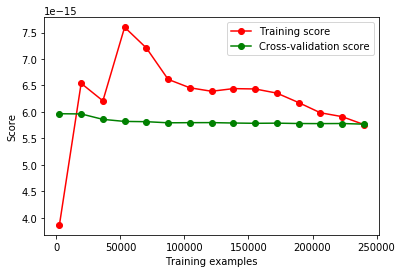

In [17]:
pyplot.figure()

train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))

pyplot.xlabel("Training examples")
pyplot.ylabel("RMSE")
pyplot.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
pyplot.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

#pyplot.legend(loc="best")